In [58]:
# fashion_pose.py : MPII를 사용한 신체부위 검출
import cv2
from music21 import *
import random
import pygame
import math

us=environment.UserSettings()
us["musescoreDirectPNGPath"]="C:/Program Files/MuseScore 3/bin/MuseScore3.exe"
us["musicxmlPath"]="C:/Program Files/MuseScore 3/bin/MuseScore3.exe"

BODY_PARTS = { "Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14}

POSE_PAIRS = [ ["Head", "Neck"], ["Neck", "RShoulder"], ["RShoulder", "RElbow"],
                ["RElbow", "RWrist"], ["Neck", "LShoulder"], ["LShoulder", "LElbow"],
                ["LElbow", "LWrist"], ["Neck", "Chest"], ["Chest", "RHip"], ["RHip", "RKnee"],
                ["RKnee", "RAnkle"], ["Chest", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"] ]
    
# 각 파일 path
protoFile = ".\openpose-master\models\pose\mpi\pose_deploy_linevec_faster_4_stages.prototxt"
weightsFile = ".\openpose-master\models\pose\mpi\pose_iter_160000.caffemodel"
 
# 위의 path에 있는 network 불러오기
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

# Use CUDA as the Backend for improving the speed
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA) 
# Let CUDA for computing the detection
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

# A threshold for deciding the fingers part are recognized or not
threshold = 0.1

In [59]:
cam = cv2.VideoCapture(1) # Camera 1 is the Web Camera in my LAb.

PositionBuffer:  [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
DiffBuffer:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GradBuffer:  [-1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000]
Note [ 1 ] Head moved
Note [ 1 ] Wrist moved
Note [ 2 ] Head moved
Meta_RestCount: 7
Note [ 3 ] Head moved
Note [ 4 ] Head moved
Note [ 5 ] Head moved
Note [ 6 ] Head moved
Note [ 7 ] Head moved
Meta_RestCount: 4
Note [ 8 ] Head moved
Note [ 8 ] Wrist moved
Note [ 9 ] Head moved
Note [ 10 ] Wrist moved
Meta_RestCount: 5
Note [ 11 ] Wrist moved
Meta_RestCount: 1
Note [ 12 ] Wrist moved
Meta_RestCount: 7
Note [ 13 ] Wrist moved
Note [ 14 ] Wrist moved
Note [ 15 ] Wrist moved
Note [ 16 ] Head moved
Note [ 16 ] Wrist moved
Meta_RestCount: 5
Note [ 17 ] Wrist moved
Note [ 18 ] Head moved
Meta_RestCount: 2
Note [ 19 ] Head moved
Note [ 19 ] Wrist moved
Note [ 20 ] Head moved
Note [

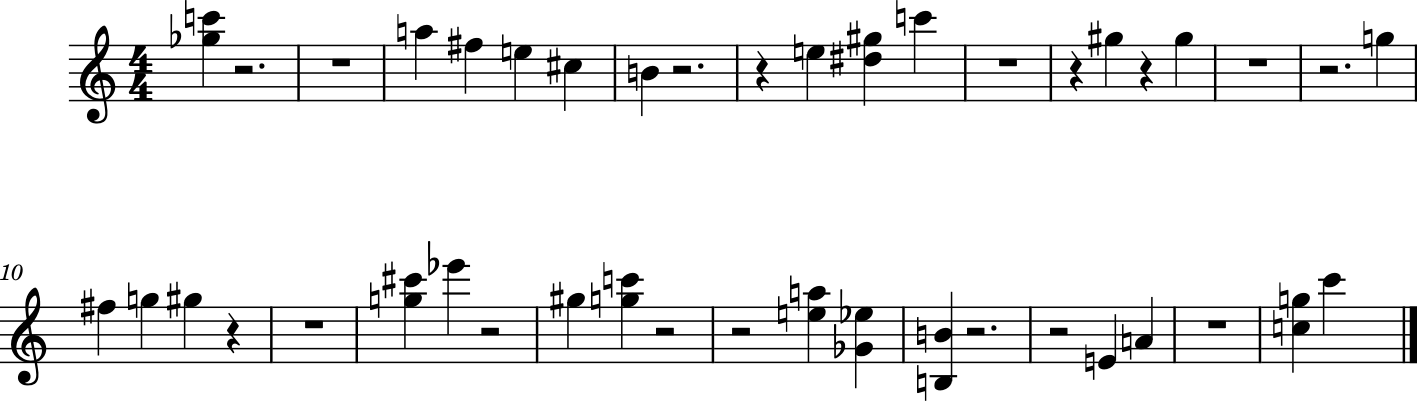

In [84]:
InputWidth = 370
InputHeight = 370
Scale = 1.0/255 # Regularize the pixel value to 0~1
iteration = 0
NoteNumber = 1

PositionBuffer = [] # 이전까지의 Positions를 저장하는 buffer를 만든다. (FIFO 느낌, average gradient로 pitch.midi 변화값 지정)
DiffBuffer = [] # Difference를 구한다. (time: n-1와 n 사이의 position들 distance 값차이 계산)
GradBuffer = []
noteBuffer = [] # 각 time에 담을 note를 저장 -> 나중에 chordify

MusicStream = stream.Stream()#음을 담는 요소

HEAD = 15
WRIST = 20
NONE = -1000

note_HEAD = 0 # Remember if the HEAD was moved at the same time.
note_L_WRIST = 0

RestCount = 0
Meta_RestCount = 0

for i in range(15):
    DiffBuffer.append(0)
    GradBuffer.append(NONE)
    PositionBuffer.append((0,0))

print("PositionBuffer: ", PositionBuffer)
print("DiffBuffer: ", DiffBuffer)
print("GradBuffer: ", GradBuffer)

while(cv2.waitKey(1) != 27):## Esc Key
    ret, frame = cam.read()   
    if not ret:
        cv2.waitKey()
        break

    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    Img = cv2.dnn.blobFromImage(frame, Scale, (InputWidth , InputHeight), (0,0,0), swapRB=False, crop=False)
    
    net.setInput(Img)
    # Get the Output from the network
    output = net.forward()
    
    points = [] # Store all the points of the joints
    
    for i in range(len(BODY_PARTS)):
        heatMap = output[0, i, :, :]
        _, confidence, _, ConfPoint = cv2.minMaxLoc(heatMap)
        
        x = int((frameWidth * ConfPoint[0])/output.shape[3])
        y = int((frameHeight * ConfPoint[1])/output.shape[2])
        
        if confidence > threshold:
            cv2.circle(frame, (x, y), 3, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.putText(frame, "{}".format(i), (x,y), cv2.FONT_HERSHEY_PLAIN, 0.7, (0, 0, 0), 1, lineType=cv2.LINE_AA)
            points.append((x,y))
        else:
            points.append(None)

                
    for pair in POSE_PAIRS:
        PartStart = pair[0]
        PartDest = pair[1]
        IdStart = BODY_PARTS[PartStart]
        IdDest = BODY_PARTS[PartDest]
        
        if points[IdStart] and points[IdDest]:
            cv2.line(frame, points[IdStart], points[IdDest], (0,255,0), 2)   

            
    # 음악적 요소 포함하기

    #Max Height는 480, Max Width는 640이다. (맨 왼쪽 위가 origin. 맨 오른쪽 아래가 (640,480))
    # 각 요소마다 다르게! 같은 경향을 갖는 joint들은 같은 수식 처리하는게 맞음. 
    # Head와 Neck - y value
    keyDetune = []
    if (points == None):
        print("Iteration [",iteration, "]: Nothing Detected")  
    else: # Something has detected
        if (points[1]!= None and DiffBuffer[1]!= None and PositionBuffer[1]!= None): # Neck detected
            DiffBuffer[1] = int(math.sqrt(pow((points[1][0] - PositionBuffer[1][0]),2) + pow(int(points[1][1] - PositionBuffer[1][1]),2)))
            #print("DiffBuffer[1 head]:",abs(DiffBuffer[1]))
            if (abs(DiffBuffer[1]) > HEAD): #Moved
                print("Note [", NoteNumber, "] Head moved")
                note_HEAD = 95 - int(points[1][1]/10) # 마지막 y값 
                #note_HEAD.pitch.midi += int(DiffBuffer[1]/HEAD) # 추가 Weight 주기
                noteBuffer.append(note_HEAD)
                #PositionBuffer = points # n-1 time값을 n time값으로 대체하기
            else:
                RestCount+= 1
        else:
            RestCount+= 1

        if (points[7]!= None and DiffBuffer[7]!= None and PositionBuffer[7]!= None): # Left Wrist detected
            DiffBuffer[7] = int(math.sqrt(pow((points[7][0] - PositionBuffer[7][0]),2) + pow(int(points[7][1] - PositionBuffer[7][1]),2)))
            #print("DiffBuffer[7 L Wrist]:",abs(DiffBuffer[7]))
            if (abs(DiffBuffer[7]) > WRIST and abs(DiffBuffer[1]-DiffBuffer[7])>10): #Moved
                print("Note [", NoteNumber, "] Wrist moved")
                note_L_WRIST = 95 - int(points[7][1]/10) # 마지막 y값 
                if (note_HEAD != note_L_WRIST):
                    noteBuffer.append(note_L_WRIST)
                    #PositionBuffer = points # n-1 time값을 n time값으로 대체하기
            else:
                RestCount+= 1
        else:
            RestCount+=1
            
        #print("RestCount_Pre: ", RestCount)
        
        if (RestCount <2): # Head, LWrist one of them was moving
            #print("RestCount: ", RestCount)
            #print("Meta_RestCount: ", Meta_RestCount)
            if(Meta_RestCount > 0): # You were on rest
                rest = note.Rest(quarterLength=Meta_RestCount)
                print("Meta_RestCount:", Meta_RestCount)
                Meta_RestCount = 0
                MusicStream.append(rest) # Add rest component     
            Result = chord.Chord(noteBuffer)
            MusicStream.append(Result) # ANd then add the Result component
            NoteNumber += 1
        else:
            Meta_RestCount += 1

    PositionBuffer = points            
    noteBuffer = []    
    RestCount = 0
    cv2.imshow("Openpose Pose API with OpenCV", frame)
    iteration += 1

#cam.release()
cv2.destroyAllWindows()
MusicStream.show()
fp = MusicStream.write('midi', 'BodyMusic_Sample.mid')
MusicStream.show('midi')

In [85]:
cam.release()